In [ ]:
%tensorflow_version 1.x
!pip install -q h5py==2.10.0
from scipy.io import loadmat
from scipy import stats
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
#import tensorflow.compat.v1 as tf1
#tf1.disable_v2_behavior()
import seaborn as sns
from pylab import rcParams
from sklearn import metrics
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from numpy import dstack
from pandas import read_csv
from sklearn.svm import SVC
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import ConvLSTM2D

TensorFlow 1.x selected.


Using TensorFlow backend.


In [ ]:
# load a single file as a numpy array
def load_file(filepath):
	df = read_csv(filepath)
  # convert activity names to number
	df.activity = pd.factorize(df.activity)[0]
	# select mean and var features
	x1 = df.iloc[:,3:9].values
	x2 = df.iloc[:,21:27].values
	x = np.append(x1,x2,axis=1)
	y = df.activity.values
	print(x.shape, y.shape)
	return x, y
# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
	# load all train
	x, y = load_file(prefix + '/sensoringData_feature_prepared_20_19.0_2'+'.csv')
	# transform for LSTM
	N_TIME_STEPS = 20
	step = 15 # faster with bigger step but accuracy degrades fast
	X = []
	Y = []
	num = y.shape[0]
	for i in range(0, num - N_TIME_STEPS, step):
			part = x[i: i + N_TIME_STEPS]
			label = stats.mode(y[i: i + N_TIME_STEPS])[0][0]
			X.append(part)
			Y.append(label)

	trainX, testX, trainy, testy = train_test_split(np.array(X), np.array(Y), test_size=0.2, random_state=42)
	 
	print(trainX.shape, trainy.shape, testX.shape, testy.shape)
	return trainX, trainy, testX, testy
# run an experiment
# load data
trainX1, trainy1, testX1, testy1 = load_dataset('drive/MyDrive/Thesis/Test Data/HAR Spain')

(499276, 12) (499276,)
(26627, 20, 12) (26627,) (6657, 20, 12) (6657,)


In [ ]:
# load a single file as a numpy array
def load_file1(filepath):
	dataframe = read_csv(filepath, header=None, delim_whitespace=True)
	return dataframe.values

# load a list of files and return as a 3d numpy array
def load_group1(filenames, prefix=''):
	loaded = list()
	for name in filenames:
		data = load_file1(prefix + name)
		loaded.append(data)
	# stack group so that features are the 3rd dimension
	loaded = dstack(loaded)
	return loaded

# load a dataset group, such as train or test
def load_dataset_group1(group, prefix=''):
	filepath = prefix + group + '/Inertial Signals/'
	# load all 9 files as a single array
	filenames = list()
	# body acceleration
	filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
	# body gyroscope
	filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
	# load input data
	X = load_group1(filenames, filepath)
	# load class output
	y = load_file1(prefix + group + '/y_'+group+'.txt')
	return X, y

def extract_features(x, y, window, step):
  num = x.shape[0]
  X = []
  Y = []
  for i in range(0, num - window, step):
    part = np.append(np.mean(x[i:i + window], axis=0),np.var(x[i: i + window], axis=0), axis=1)
    part = np.mean(part,axis=0)
    label = stats.mode(y[i: i + window])[0][0]
    X.append(part)
    Y.append(label)
  return np.array(X), np.array(Y)


# load the dataset, returns train and test X and y elements
def load_dataset1(prefix=''):
  # load all train
  trainX, trainy = load_dataset_group1('train', prefix + 'HARDataset/')
  print(trainX.shape, trainy.shape)
  # load all test
  testX, testy = load_dataset_group1('test', prefix + 'HARDataset/')
  print(testX.shape, testy.shape)
  # zero-offset class values
  trainy = trainy - 1
  testy = testy - 1
  window = 10
  # calculate mean and var
  window = 10
  step = 1
  x, y = extract_features(np.append(trainX,testX,axis=0), np.append(trainy,testy,axis=0), window, step)

  ind = np.argsort( y[:,0] )
  x = x[ind]
  y = y[ind]

  x = x[1832:4692]
  y = y[1832:4692]
  x[:, [2, 1,5,4]] = x[:, [1, 2,4,5]]
  # transform for LSTM
  N_TIME_STEPS = 20
  step = 1 # faster with bigger step but accuracy degrades fast
  X = []
  Y = []
  num = y.shape[0]
  for i in range(0, num - N_TIME_STEPS, step):
    part = x[i: i + N_TIME_STEPS]
    label = stats.mode(y[i: i + N_TIME_STEPS])[0][0]
    X.append(part)
    Y.append(label)
  
  trainX, testX, trainy, testy = train_test_split(np.array(X), np.array(Y), test_size=0.2, random_state=42)
  testy = testy.reshape(-1)
  trainy = trainy.reshape(-1)
  print(trainX.shape, trainy.shape, testX.shape, testy.shape)
  # offset upstairs label 4 abd downstair 5
  trainy = trainy + 3
  testy = testy + 3
  return trainX, trainy, testX, testy

# load data
trainX2, trainy2, testX2, testy2 = load_dataset1('drive/MyDrive/Thesis/Test Data/')

(7352, 128, 6) (7352, 1)
(2947, 128, 6) (2947, 1)
(2272, 20, 12) (2272,) (568, 20, 12) (568,)


In [ ]:
# append train data
trainX = np.append(trainX1,trainX2,axis=0)
testX = np.append(testX1,testX2,axis=0)
trainy = np.append(trainy1,trainy2,axis=0)
testy = np.append(testy1,testy2,axis=0)

print(trainX.shape, trainy.shape, testX.shape, testy.shape)

(28899, 20, 12) (28899,) (7225, 20, 12) (7225,)


In [ ]:
#def classify_svm(x_train, y_train, x_test):
#    # train label SVM
#    clf = SVC(kernel='rbf', class_weight='balanced', C=1e3, gamma=0.1)
#    clf = clf.fit(x_train, y_train)

    # predict using svm
#    y_pred = clf.predict(x_test)

#    return y_pred

#y_pred = classify_svm(testX, testy, testX)
#from sklearn.metrics import accuracy_score
#accuracy_score(testy, y_pred)

In [ ]:
# fit and evaluate a model
def evaluate_model(trainX, trainy, testX, testy):
	# define model
	verbose, epochs, batch_size = 1, 10, 64
	n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
	# reshape into subsequences (samples, time steps, rows, cols, channels)
	n_steps, n_length = 2, 10
	trainX = trainX.reshape((trainX.shape[0], n_steps, 1, n_length, n_features))
	testX = testX.reshape((testX.shape[0], n_steps, 1, n_length, n_features))
	# define model
	model = Sequential()
	model.add(ConvLSTM2D(filters=64, kernel_size=(1,3), activation='relu', input_shape=(n_steps, 1, n_length, n_features)))
	model.add(Dropout(0.5))
	model.add(Flatten())
	model.add(Dense(100, activation='relu'))
	model.add(Dense(n_outputs, activation='softmax'))
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	# fit network
	history = model.fit(trainX, trainy, validation_split=0.33, epochs=epochs, batch_size=batch_size, verbose=verbose)
	# evaluate model
	_, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
	return model,history,accuracy


# repeat experiment
# one hot encode y
trainy = to_categorical(trainy)
testy = to_categorical(testy)
model,model_history,score = evaluate_model(trainX, trainy, testX, testy)
score = score * 100.0
print('>#%d: %.3f' % (1, score))



Train on 19362 samples, validate on 9537 samples
Epoch 1/10
19362/19362 [==============================] - 10s 534us/step - loss: 0.6866 - accuracy: 0.7790 - val_loss: 2.6717 - val_accuracy: 0.6372
Epoch 2/10
19362/19362 [==============================] - 10s 500us/step - loss: 0.4140 - accuracy: 0.8529 - val_loss: 3.6249 - val_accuracy: 0.6667
Epoch 3/10
19362/19362 [==============================] - 9s 490us/step - loss: 0.3292 - accuracy: 0.8880 - val_loss: 5.6280 - val_accuracy: 0.6821
Epoch 4/10
19362/19362 [==============================] - 10s 499us/step - loss: 0.2741 - accuracy: 0.9106 - val_loss: 6.2929 - val_accuracy: 0.6991
Epoch 5/10
19362/19362 [==============================] - 10s 491us/step - loss: 0.2491 - accuracy: 0.9186 - val_loss: 6.7523 - val_accuracy: 0.6994
Epoch 6/10
19362/19362 [==============================] - 9s 488us/step - loss: 0.2310 - accuracy: 0.9255 - val_loss: 7.2853 - val_accuracy: 0.7077
Epoch 7/10
19362/19362 [==============================] - 1

In [ ]:
# reshape data into time steps of sub-sequences
n_features, n_steps, n_length = trainX.shape[2], 2, 10
trainX = trainX.reshape((trainX.shape[0], n_steps, 1, n_length, n_features))
testX = testX.reshape((testX.shape[0], n_steps, 1, n_length, n_features))
X = np.append(trainX, testX, axis=0)
Y = np.append(trainy, testy, axis=0)
Y_cat = np.argmax(Y, axis=1)
ind = np.argsort( Y_cat[:] )
X = X[ind]
Y = Y[ind]
Y_pred = model.predict(np.array(X))
np.shape(Y_pred)

(52766, 6)

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


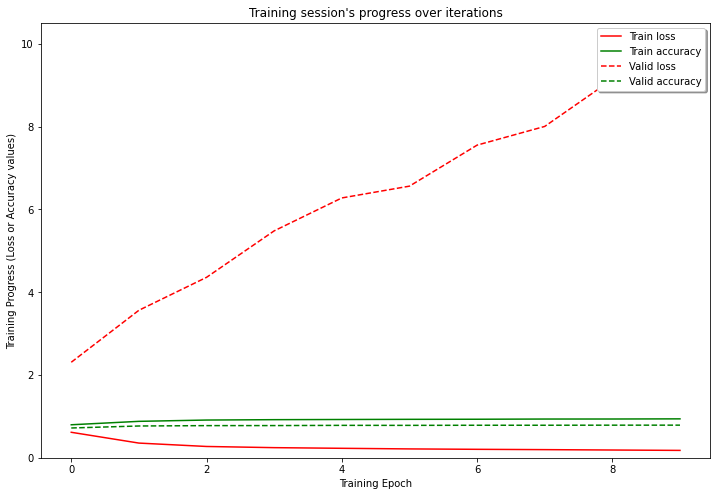

In [ ]:
print(model_history.history.keys())
plt.figure(figsize=(12, 8))
plt.plot(np.array(model_history.history['loss']), "r-", label="Train loss")
plt.plot(np.array(model_history.history['accuracy']), "g-", label="Train accuracy")
plt.plot(np.array(model_history.history['val_loss']), "r--", label="Valid loss")
plt.plot(np.array(model_history.history['val_accuracy']), "g--", label="Valid accuracy")
plt.title("Training session's progress over iterations")
plt.legend(loc='upper right', shadow=True)
plt.ylabel('Training Progress (Loss or Accuracy values)')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.show()

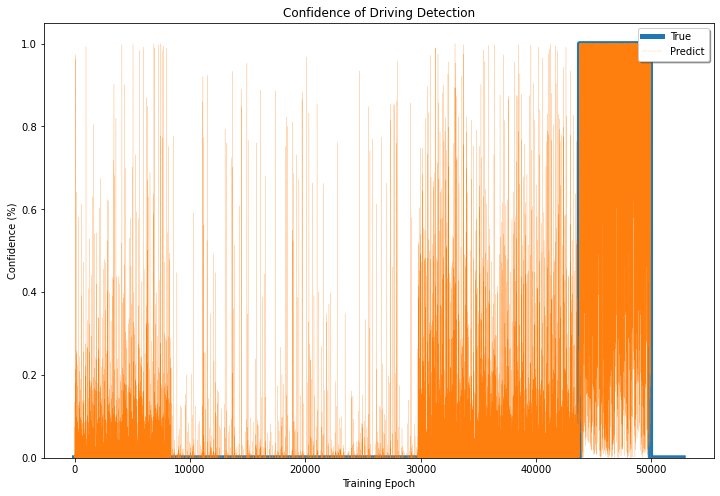

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(np.array(Y[:,3]), linewidth=5.0, label="True")
plt.plot(np.array(Y_pred[:,3]), '--', linewidth=0.20, label="Predict")
plt.title("Confidence of Driving Detection")
plt.legend(loc='upper right', shadow=True)
plt.ylabel('Confidence (%)')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.show()

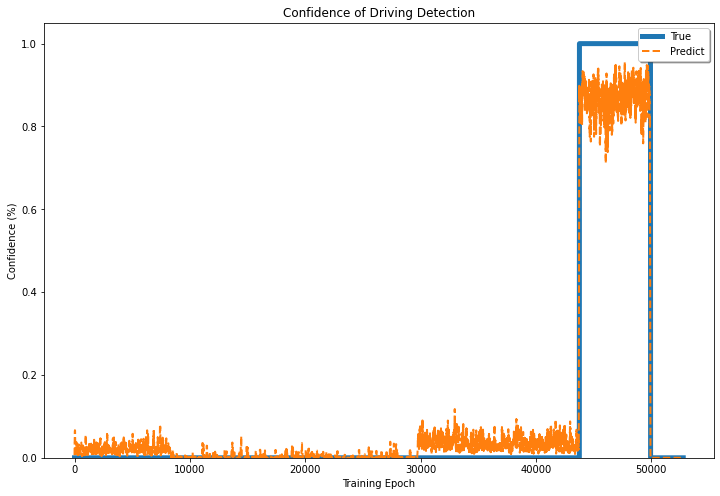

In [ ]:
N = 50
y_f = np.convolve(np.array(Y_pred[:,3]), np.ones(N)/N, mode='valid')

plt.figure(figsize=(12, 8))
plt.plot(np.array(Y[:,3]), linewidth=5.0, label="True")
plt.plot(y_f, '--', linewidth=2.0, label="Predict")
plt.title("Confidence of Driving Detection")
plt.legend(loc='upper right', shadow=True)
plt.ylabel('Confidence (%)')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.show()

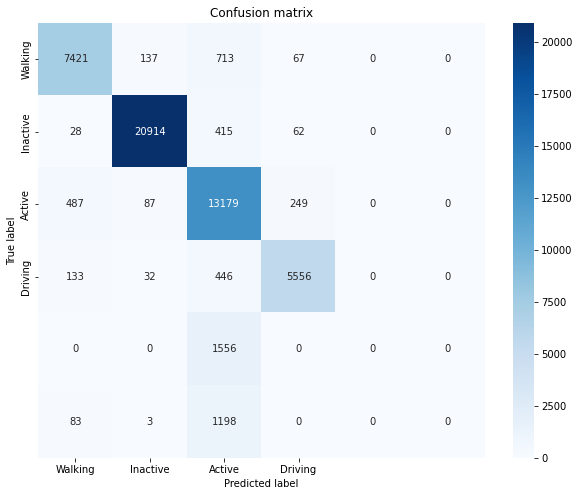

In [ ]:
LABELS = ['Walking','Inactive','Active','Driving']
Y_cat = np.argmax(Y, axis=1)
Y_pred_cat = np.argmax(Y_pred, axis=1)
confusion_matrix = metrics.confusion_matrix(Y_cat, Y_pred_cat)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d",cmap="Blues");
plt.title("Confusion matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show();

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(Y_cat2, Y_pred2_cat)

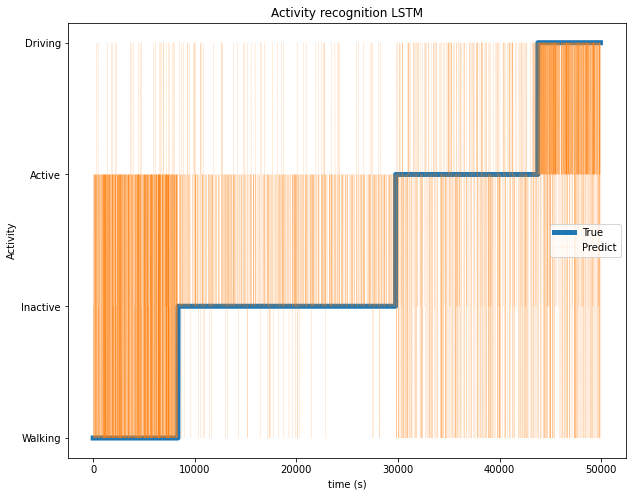

In [ ]:
def visualize_activity_recognition(t, label_true, label_pred_mode, label_classes,name):
    plt.figure(figsize=(10, 8))
    plt.title("Activity recognition {}".format(name))
    plt.plot(t, label_true, linewidth=5.0)
    plt.plot(t.reshape(-1), label_pred_mode.reshape(-1), '--', linewidth=0.10)
    plt.yticks(np.arange(len(label_classes)), label_classes)
    plt.xlabel("time (s)")
    plt.ylabel("Activity")
    plt.legend(["True", "Predict"])
    plt.show()

num = len(Y_cat)
t = np.arange(0,num*1,1)
visualize_activity_recognition(t, Y_cat, Y_pred_cat, LABELS,"LSTM")

In [ ]:
model.save('drive/MyDrive/Thesis/Test Data/HAR Spain/Driving_model')
pickle.dump(model_history.history, open("drive/MyDrive/Thesis/Test Data/HAR Spain/Driving_model_history", "wb"))
print("Saved model to disk")

Saved model to disk
